In [120]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning
from scipy.stats import binom_test

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict

from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [121]:
# test model
test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/chosen_model/chosen_model"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset_train = 'cingulate_HCP_half_2_NEOFAC_C'

# load the data
train_df = pd.read_csv(test_model+'/'+dataset_train+'_embeddings/train_val_embeddings.csv', index_col=0)
train_df.sort_index(inplace=True)

In [122]:
dataset_test = 'cingulate_ACCpatterns_0'

test_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
test_df.sort_index(inplace=True)

# load the labels
prediction_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
prediction_df.sort_index(inplace=True)

In [123]:
len(test_df)

170

## correlation functions

In [124]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [125]:
def cross_correlation(model_path, dataset='cingulate_ACCpatterns_1'):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    fig, axs = plt.subplots(1, 4, figsize=(30,10)) 

    latent_df = full_df.iloc[:,1:]
    corr = latent_df.corr()
    axs[0] = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[0]
            )

    latent_df = full_df[full_df.label == 0].iloc[:,1:]
    corr0 = latent_df.corr()
    axs[1] = sns.heatmap(
            corr0, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[1]
            )

    latent_df = full_df[full_df.label == 1].iloc[:,1:]
    corr1 = latent_df.corr()
    axs[2] = sns.heatmap(
            corr1, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[2]
            )

    corrdiff = (corr1-corr0)
    axs[3] = sns.heatmap(
            corrdiff, 
            vmin=corrdiff.min().min(), vmax=corrdiff.max().max(), center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[3]
            )


In [126]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False, dataset='cingulate_ACCpatterns_1'):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(16,12))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

In [127]:
def full_visualization(model_path, dataset='cingulate_ACCpatterns_1'):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/"+dataset+"_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    return visualize_umaps(model_path, dataset)

In [128]:
# test model
# visual_embs = full_visualization(test_model)

## Visualize each variable of the latent

x, full_df and colors shapes:  (171, 10) (171, 11) (171, 10)
(10,) (10,) (10,)


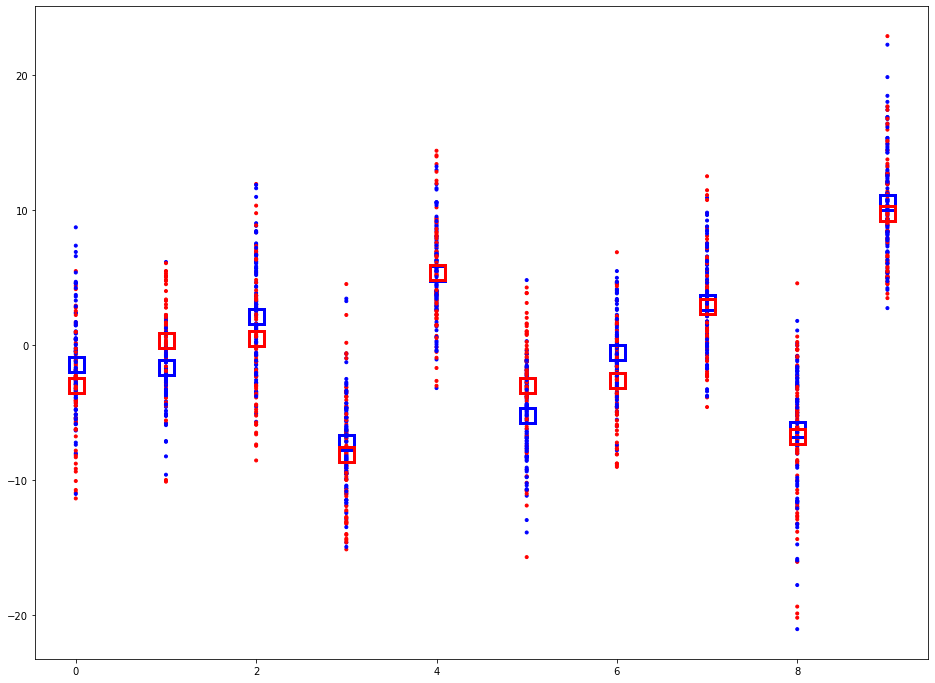

In [129]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False)

In [130]:
def do_pca(model_path, dataset=dataset_test):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = latent_df.shape[1]
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = pca.transform(label0_df)
    mean0 = np.mean(transformed0, axis=0)
    print(mean0.shape)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = pca.transform(label1_df)
    mean1 = np.mean(transformed1, axis=0)
    print(mean1.shape)

    idx = np.arange(n_components)+1
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

    limit_df = n_components

    #make scree plot
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    fig, axs = plt.subplots(1, 2, figsize=(30,10)) 
    [t.set_color('white') for t in axs[0].xaxis.get_ticklabels()]
    [t.set_color('white') for t in axs[0].yaxis.get_ticklabels()]
    axs[0].set_title('Explained variance across principal components', fontsize=14)
    axs[0].set_xlabel('Principal component', fontsize=12)
    axs[0].set_ylabel('Explained variance', fontsize=12)
    sns.barplot(ax=axs[0], x=idx[:limit_df], y='explained variance', data=df_explained_variance, palette='summer')
    axs[0] = axs[0].twinx()
    axs[0].grid(False)
    axs[0].set_ylabel('Cumulative', fontsize=14)
    sns.lineplot(ax=axs[0], x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance, color='#fc8d59')

    N, D = transformed.shape
    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs[1].scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs[1].scatter(x, transformed1, c='red', marker='.')
    x = np.arange(D)
    axs[1].plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)
    axs[1].plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()


In [131]:
def do_dictionary_learning(data_df, n_components=10, transform_n_nonzero_coefs=1):
    data_df_local = data_df.copy()
    full_df_local = pd.DataFrame()
    # Makes dictionary learning over all embeddings
    latent_df = data_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = n_components
    dict_learner = DictionaryLearning(n_components=n_components,
                                      transform_n_nonzero_coefs=transform_n_nonzero_coefs,
                                      alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = data_df_local.index
    full_df_local = pd.merge(data_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local, dict_learner

In [132]:
def plot_patterns(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Transforms over label0 dataframe
    label0_df = full_df_local[full_df_local['label'] == 0].iloc[:,1:]
    transformed0 = label0_df.values

    # Transforms over label1 dataframe
    label1_df = full_df_local[full_df_local['label'] == 1].iloc[:,1:]
    transformed1 = label1_df.values

    fig, axs = plt.subplots(1, 1, figsize=(10,7)) 

    _, D = transformed0.shape

    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs.scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs.scatter(x, transformed1, c='red', marker='.')

    x = np.arange(D)

    masked0 = np.ma.masked_equal(transformed0, 0.)
    mean0 = masked0.mean(axis=0)
    axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    masked1 = np.ma.masked_equal(transformed1, 0.)
    mean1 = masked1.mean(axis=0)
    axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()

In [133]:
def return_predictions(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res = np.zeros(2*n_patterns)

    # Makes random permutation to produce random label
    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)

    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df_local[full_df_local[c] < 0.]
        res[2*i] = df['label'].mean()
        df = full_df_local[full_df_local[c] > 0.]
        res[2*i+1] = df['label'].mean()

    return res

def plot_predictions(prediction_df, transformed_df):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_random = np.zeros((20, 2*n_patterns))

    # Loads labels
    mean_label = prediction_df_local['label'].mean()
    print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res = return_predictions(prediction_df_local, transformed_df_local)
    for i in range(20):
        res_random[i,:] = return_predictions(prediction_df_local, transformed_df_local, True)
    
    for i in range(20):
        plt.scatter(x, res_random[i], c='grey')

    plt.scatter(x, res, c='red')
    plt.plot(mean_label*np.ones(2*n_patterns))
    plt.ylim((0,1))
    return res   

In [134]:
def return_sum(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res_sum = np.zeros(2*n_patterns)
    res_len = np.zeros(2*n_patterns)

    full_df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df[full_df[c] < 0.]
        res_sum[2*i] = df['label'].sum()
        res_len[2*i] = len(df)
        df = full_df[full_df[c] > 0.]
        res_sum[2*i+1] = df['label'].sum()
        res_len[2*i+1] = len(df)

    return res_sum, res_len


def do_t_test(prediction_df, transformed_df, show=True, nb_components=10):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_p = np.zeros(2*n_patterns)

    # Mean labels
    mean_label = prediction_df_local['label'].mean()
    # print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res_sum, res_len = return_sum(prediction_df_local, transformed_df_local)
    
    for i in range(2*n_patterns):
        res_p[i] = binom_test(res_sum[i], n=res_len[i], p=mean_label, alternative='two-sided')

    if show:
        plt.scatter(x, -np.log10(res_p))
        plt.plot(-np.log10(0.05/(2*nb_components))*np.ones(2*n_patterns))

    return res_p   

In [135]:
def give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, show=True, nb_components=10):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)
    nb_subjects = np.zeros(len(res_p))
    nb_subjects_relevant = 0
    exact_nb_subjects_relevant = 0
    log_p_nb_subjects = 0
    max_auc_score = 0.0
    auc_score = np.zeros(len(res_p))
    # print(len(df.columns))
    for i in range(1,len(df.columns)):
        # print(df.iloc[:,[i]].columns)
        d = df[df.iloc[:,i] < 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        # print(np.unique(d.label.values).shape)
        nb_subjects[2*i-2] = len(d)
        auc_score[2*i-2] = accuracy_score(d.label, d.iloc[:,i])
        if 2.*d.label.sum() < (len(d.label)):
            exact_nb_subjects = len(d.label)-d.label.sum()
        else:
            exact_nb_subjects = d.label.sum()
        
        if res_p[2*i-2] < 0.05/nb_components:
            nb_subjects_relevant += nb_subjects[2*i-2]
            max_auc_score = max(auc_score[2*i-2], max_auc_score)
            exact_nb_subjects_relevant += exact_nb_subjects
            log_p_nb_subjects += -np.log10(res_p[2*i-2])*exact_nb_subjects

        d = df[df.iloc[:,i] > 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        nb_subjects[2*i-1] = len(d)
        auc_score[2*i-1] = accuracy_score(d.label, d.iloc[:,i])
        if 2.*d.label.sum() < (len(d.label)):
            exact_nb_subjects = len(d.label)-d.label.sum()
        else:
            exact_nb_subjects = d.label.sum()
        
        if res_p[2*i-1] < 0.05/nb_components:
            nb_subjects_relevant += nb_subjects[2*i-1]
            max_auc_score = max(auc_score[2*i-1], max_auc_score)
            exact_nb_subjects_relevant += exact_nb_subjects
            log_p_nb_subjects += -np.log10(res_p[2*i-2])*exact_nb_subjects
            
    # print(d)
    if show:
        x = np.arange(len(res_p))
        plt.scatter(x, auc_score)
        plt.ylabel('accuracy_score')
        # plt.scatter(res_p, auc_score)
        # plt.xlabel('p value')
        # plt.ylabel('auc_score')
    return nb_subjects_relevant, max_auc_score, exact_nb_subjects_relevant, log_p_nb_subjects

In [136]:
def test_dictionary_learning(dict_learner, test_df, n_components):
    test_df_local = test_df.copy()
    full_df_local = pd.DataFrame()
    latent_df = test_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    transformed = dict_learner.transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = test_df_local.index
    full_df_local = pd.merge(test_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local


## Non-zeros=1, nb_components=4

In [137]:
full_df, transformed_train_df, dict_learner = do_dictionary_learning(data_df=train_df, n_components=4, transform_n_nonzero_coefs=1)

In [138]:
full_df, transformed_df = test_dictionary_learning(dict_learner=dict_learner, test_df=test_df, n_components=4)

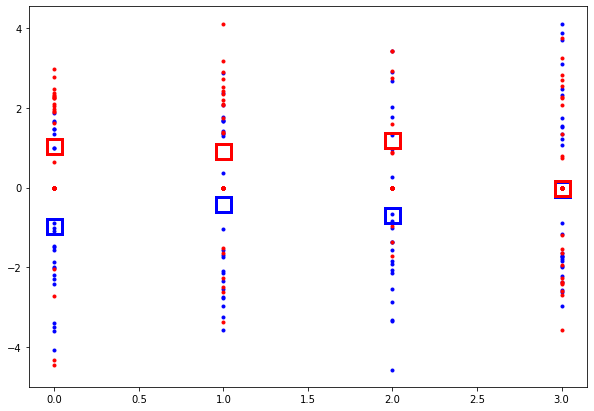

In [139]:
plot_patterns(prediction_df, transformed_df, random=False)

In [140]:
# plot_patterns(prediction_df, transformed_df, random=True)

In [141]:
def plot_patterns_separated(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    l = len(full_df_local)
    d = len(full_df_local.columns)
    res = pd.DataFrame(np.zeros((l,3)), index=full_df_local.index, columns=["val", "label", "pat"])
    patterns = ["Ap", "Am", "Bp", "Bm", "Cp", "Cm", "Dp", "Dm"]

    for index, row in transformed_df_local.iterrows():
        idx_nonzero = int(np.nonzero(row.values)[0])
        val_nonzero = row.iloc[idx_nonzero]
        res.loc[index, "val"] = np.abs(val_nonzero)
        res.loc[index, "label"] = prediction_df_local.loc[index, "label"]
        if val_nonzero > 0.:
            res.loc[index, "pat"] = patterns[2*idx_nonzero]
        else:
            res.loc[index, "pat"] = patterns[2*idx_nonzero+1]

    res.sort_values(ascending=True, by='pat', inplace=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    # g = sns.pointplot(data=res, x=res.pat, y="val", hue = "label", alpha=[0.5,0.5], palette=['blue', 'red'], markers=['v', 's'], scale=2, linestyles=['None', 'None'], ax=ax)
    # plt.setp(g.collections, alpha=0.5)
    # plt.setp(g.lines, alpha=.5) 
    sns.stripplot(data=res[res.label==0], x=res.pat, y="val", hue = "label", marker='v', palette=['blue'], size=7, jitter=.2, ax=ax)
    sns.stripplot(data=res[res.label==1], x=res.pat, y="val", hue = "label", marker='s', palette=['red'], size=7, jitter=.2, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[1], handles[0]], ["paracingular", "no paracingular"], labelspacing=2)

    plt.show()

    return res

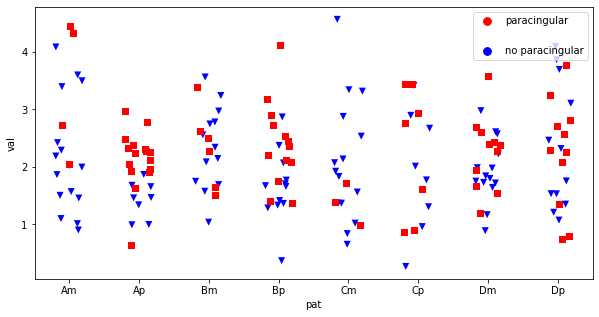

In [142]:
res_df = plot_patterns_separated(prediction_df, transformed_df)

In [165]:
res_df2 = res_df.copy()
res_df2["atom"] = res_df2["pat"].apply(lambda x: x[0])
res_df2["sign"] = res_df2["pat"].apply(lambda x: x[1])
res_df2.rename(columns={"label": "gender"}, inplace=True)
res_df2.gender = res_df2.gender.apply(lambda x: "male" if x== 1.0 else "female")
# res_df2.sort_values(ascending=True, by='atom', inplace=True)
# res_df2.sort_values(ascending=False, by='sign', inplace=True)
res_df2 = res_df2.sort_values(['atom', 'sign'], ascending=[True, False])
res_df2.drop(columns="pat", inplace=True)

In [166]:
res_df2.head()

,val,gender,atom,sign
Subject,,,,
nih_chp_05330_t1,1.461494,female,A,p
sub-inhibition22_ses-pretraining_T1w,2.305709,male,A,p
sub-inhibition18_ses-pretraining_T1w,2.107287,male,A,p
nih_chp_02488_t1,1.923138,male,A,p
nih_chp_02563_t1,0.632589,male,A,p


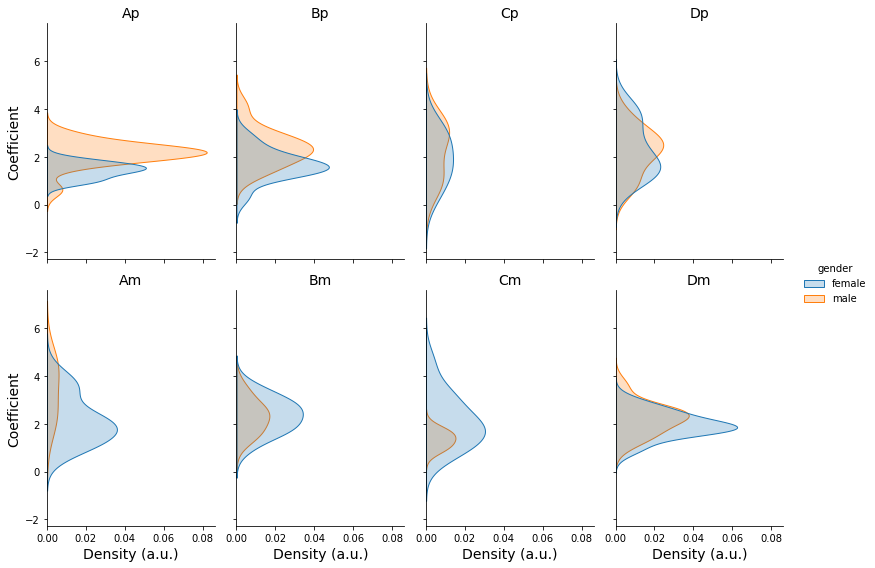

In [167]:
g = sns.displot(
    data=res_df2, y="val", hue="gender", col="atom", row="sign",
    fill=True,
    kind="kde", height=4, aspect=.7,
)
g.set_axis_labels("Density (a.u.)", "Coefficient")
g.set_titles("{col_name}{row_name}")

In [143]:
def plot_patterns_separated_without_labels(transformed_df, random=False):
    # Makes local copy
    transformed_df_local = transformed_df.copy()
    full_df_local = transformed_df_local

    l = len(full_df_local)
    d = len(full_df_local.columns)
    res = pd.DataFrame(np.zeros((l,3)), index=full_df_local.index, columns=["val", "label", "pat"])
    patterns = ["Ap", "Am", "Bp", "Bm", "Cp", "Cm", "Dp", "Dm"]

    for index, row in transformed_df_local.iterrows():
        idx_nonzero = int(np.nonzero(row.values)[0])
        val_nonzero = row.iloc[idx_nonzero]
        res.loc[index, "val"] = np.abs(val_nonzero)
        res.loc[index, "label"] = 0
        if val_nonzero > 0.:
            res.loc[index, "pat"] = patterns[2*idx_nonzero]
        else:
            res.loc[index, "pat"] = patterns[2*idx_nonzero+1]

    res.sort_values(ascending=True, by='pat', inplace=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    g = sns.pointplot(data=res, x=res.pat, y="val", hue = "label", alpha=[0.5,0.5], palette=['blue', 'red'], markers=['v', 's'], scale=2, linestyles=['None', 'None'], ax=ax)
    plt.setp(g.collections, alpha=0.5)
    # plt.setp(g.lines, alpha=.5) 
    sns.stripplot(data=res[res.label==0], x=res.pat, y="val", hue = "label", marker='v', palette=['blue'], jitter=.1, ax=ax)
    # sns.stripplot(data=res[res.label==1], x=res.pat, y="val", hue = "label", marker='s', palette=['red'], jitter=.1, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([],[], frameon=False)
    
    plt.show()

    return res

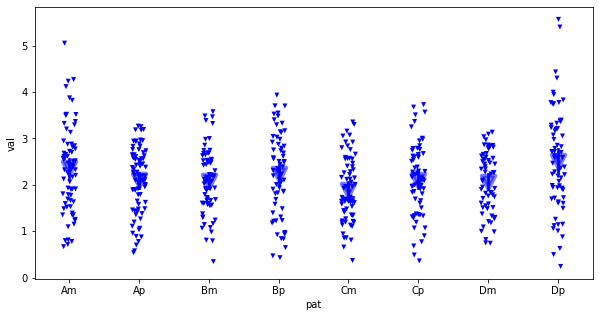

In [144]:
res_train_df = plot_patterns_separated_without_labels(transformed_train_df)

In [145]:
def plotting_hist(res_df):
    patterns = ["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"]

    plt.rc('axes', labelsize=14) 
    f, axs = plt.subplots(4, 2, figsize=(11, 22))

    for i, pat in enumerate(patterns):
        axs[i%4,int(i/4)].hist(res_df[(res_df.label==0) & (res_df.pat==pat)].val, alpha=0.5)
        axs[i%4,int(i/4)].hist(res_df[(res_df.label==1) & (res_df.pat==pat)].val, alpha=0.5)

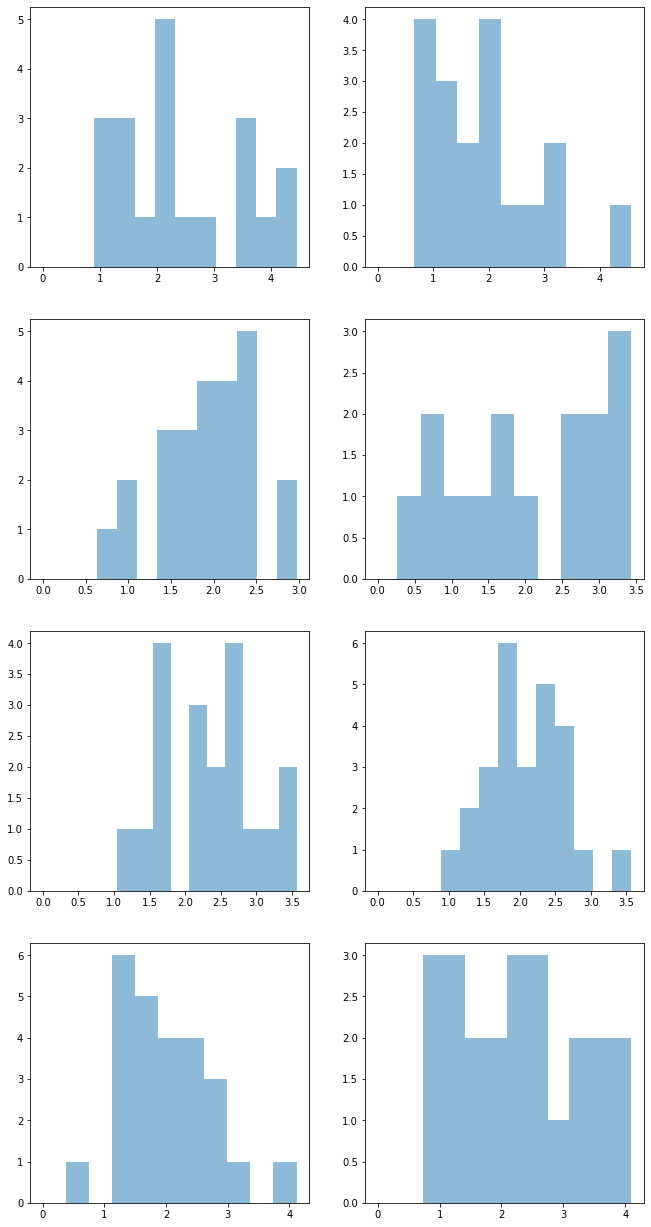

In [146]:
res0_df = res_df.copy()
res0_df.label=0
plotting_hist(res0_df)

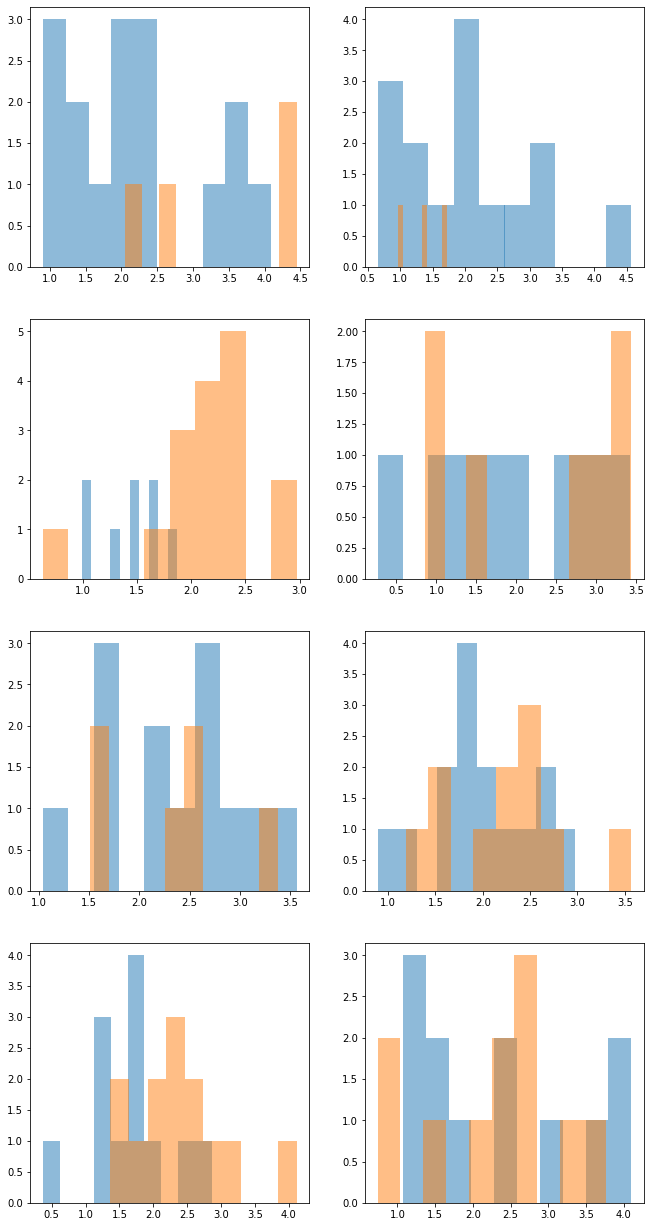

In [147]:
plotting_hist(res_df)

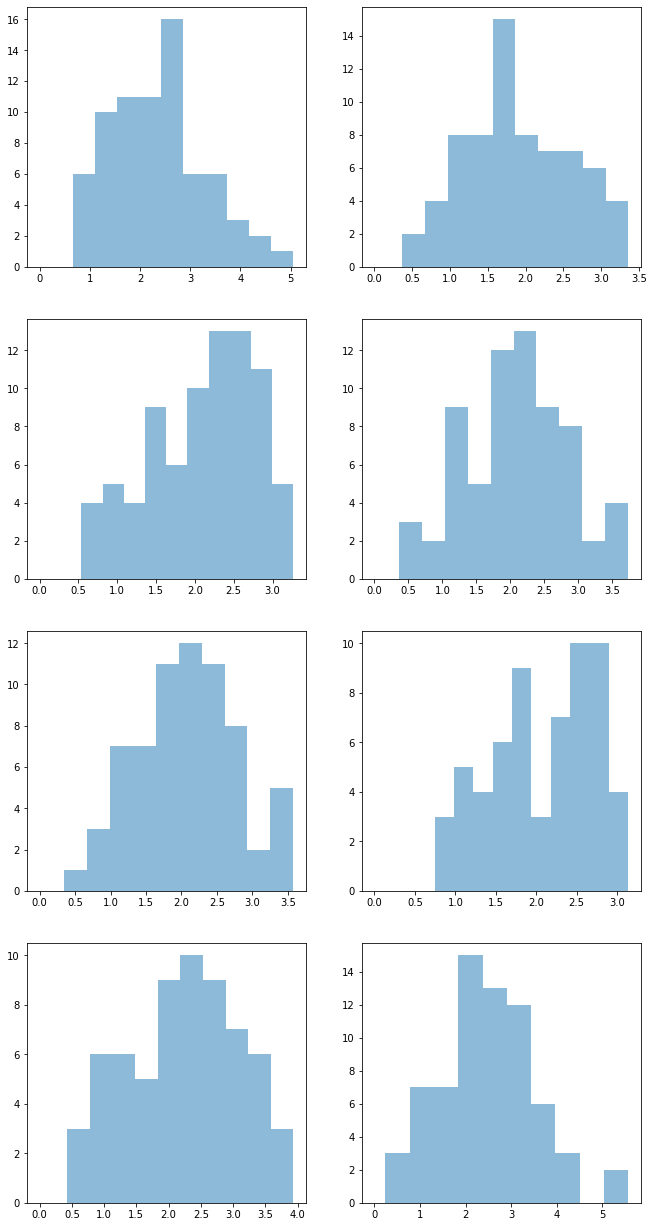

In [148]:
plotting_hist(res_train_df)

Mean label = 0.4176470588235294


array([0.2       , 0.66666667, 0.31578947, 0.52      , 0.16666667,
       0.46666667, 0.42307692, 0.47826087])

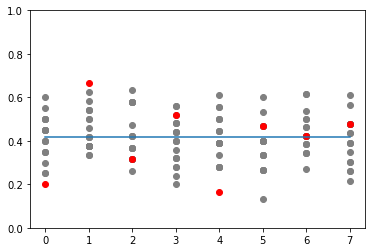

In [149]:
plot_predictions(prediction_df, transformed_df)

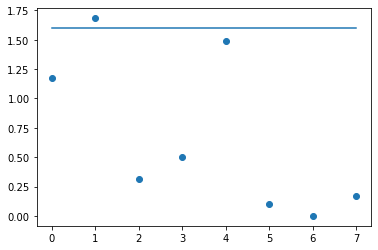

In [150]:
res_p = do_t_test(prediction_df, transformed_df, nb_components=1)

(0, 0.0, 0, 0)

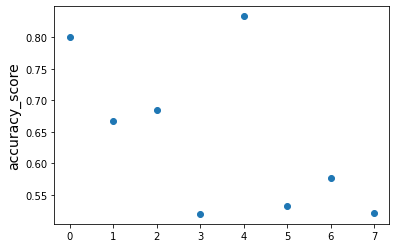

In [151]:
give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, nb_components=4)

## Visualize umap

In [152]:
def compute_umap(df):
    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [153]:
def display_umaps_true_labels(visual_embs_train, reducer, test_df, prediction_df, verbose=False):
    if verbose:
        print("Test df:")
        print(test_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    if verbose:
        print("UMAP embeddings")
        print(visual_embs_train.shape)
        print(visual_embs_train[:5])
    visual_embs_test = reducer.transform(test_df)

    ## plot the graphs

    plt.figure()
    plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c='green', alpha=0.1)

    # plot for true labels
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs_test[:,0], visual_embs_test[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    plt.show()

    return pd.DataFrame(visual_embs_test, index=test_df.index.values)

In [154]:
visual_embs, reducer = compute_umap(test_df)

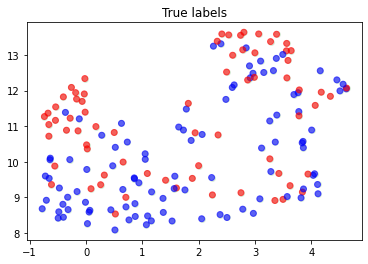

In [155]:
df_umap = display_umaps_true_labels(visual_embs, reducer, test_df, prediction_df, verbose=False)

In [156]:
transformed_df.head()

,trans_0,trans_1,trans_2,trans_3
ID,,,,
1-03HUBJO_t0,0.000000,0.000000,2.933414,0.0
1-08ANDTI_t0,0.000000,2.104835,0.000000,0.0
1-11LEBJO_t0,0.000000,2.534148,0.000000,0.0
1-15LEHMI_t0,0.000000,0.000000,2.012717,0.0
1-17COLMA_t0,-1.570589,0.000000,0.000000,0.0


In [157]:
transformed_df2 = transformed_df.copy()

In [158]:
transformed_df2["label"] = transformed_df.trans_2.apply(lambda x: 1 if x > 0. else 0)

In [159]:
transformed_df2.head()

,trans_0,trans_1,trans_2,trans_3,label
ID,,,,,
1-03HUBJO_t0,0.000000,0.000000,2.933414,0.0,1
1-08ANDTI_t0,0.000000,2.104835,0.000000,0.0,0
1-11LEBJO_t0,0.000000,2.534148,0.000000,0.0,0
1-15LEHMI_t0,0.000000,0.000000,2.012717,0.0,1
1-17COLMA_t0,-1.570589,0.000000,0.000000,0.0,0


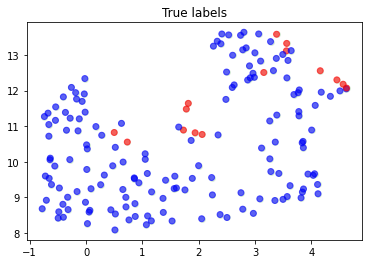

In [160]:
df_umap = display_umaps_true_labels(visual_embs, reducer, test_df, transformed_df2, verbose=False)

## Correspondance des sujets ACCpatterns

In [161]:
transformed_df2[transformed_df2.label==1].index

Index(['1-03HUBJO_t0', '1-15LEHMI_t0', '1-40AYMJU_t0', 'a0005_t1_s03',
       'a0009_t1_02_s03', 'a0019_t1_s03', 'a0038_t1_s03', 'e0068_t1_s03',
       'nih_chp_02769_t1', 'nih_chp_04910_t1', 'nih_chp_04911_t1',
       'nih_chp_05362_t1', 'sub-active25_ses-pretraining_T1w',
       'sub-inhibition03_ses-pretraining_T1w',
       'sub-inhibition04_ses-pretraining_T1w'],
      dtype='object', name='ID')

In [162]:
transformed_df2[transformed_df2.label==1]

,trans_0,trans_1,trans_2,trans_3,label
ID,,,,,
1-03HUBJO_t0,0.0,0.0,2.933414,0.0,1
1-15LEHMI_t0,0.0,0.0,2.012717,0.0,1
1-40AYMJU_t0,0.0,0.0,1.599749,0.0,1
a0005_t1_s03,0.0,0.0,0.855724,0.0,1
a0009_t1_02_s03,0.0,0.0,1.306772,0.0,1
a0019_t1_s03,0.0,0.0,2.748906,0.0,1
a0038_t1_s03,0.0,0.0,2.673840,0.0,1
e0068_t1_s03,0.0,0.0,2.898539,0.0,1
nih_chp_02769_t1,0.0,0.0,0.960764,0.0,1


In [163]:
prediction_df[transformed_df2.label==1]

,label,predicted_0,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,predicted_7,predicted_8,...,predicted_243,predicted_244,predicted_245,predicted_246,predicted_247,predicted_248,predicted_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
1-03HUBJO_t0,1,0.826617,0.869319,0.812548,0.815270,0.843197,0.803266,0.791433,0.875387,0.833395,...,0.850910,0.744179,0.778809,0.783755,0.836368,0.858805,0.827344,0.823589,0.819331,0.826617
1-15LEHMI_t0,0,0.564967,0.591834,0.554163,0.557975,0.575149,0.560511,0.546634,0.590924,0.568416,...,0.579235,0.529069,0.535848,0.532161,0.570636,0.575294,0.564768,0.562076,0.562144,0.564967
1-40AYMJU_t0,1,0.729463,0.773155,0.714927,0.718339,0.746002,0.710342,0.696664,0.778199,0.735934,...,0.753620,0.657290,0.683618,0.685730,0.739035,0.758919,0.729956,0.726121,0.723615,0.729463
a0005_t1_s03,1,0.152302,0.124661,0.156848,0.158362,0.142362,0.178484,0.174197,0.114972,0.147479,...,0.136507,0.209148,0.174841,0.163425,0.146206,0.121192,0.151052,0.152656,0.156839,0.152302
a0009_t1_02_s03,0,0.590799,0.622227,0.578980,0.582838,0.602567,0.583626,0.569429,0.622473,0.594926,...,0.607521,0.548034,0.558048,0.555242,0.597399,0.605148,0.590717,0.588439,0.587547,0.590799
a0019_t1_s03,1,0.595665,0.627979,0.583649,0.587518,0.607740,0.587978,0.573715,0.628445,0.599923,...,0.612861,0.551598,0.562219,0.559578,0.602445,0.610783,0.595605,0.593265,0.592317,0.595665
a0038_t1_s03,0,0.665406,0.704597,0.651825,0.655491,0.680150,0.651274,0.640315,0.707789,0.670964,...,0.686761,0.606637,0.626834,0.626721,0.673844,0.688943,0.665656,0.662985,0.661309,0.665406
e0068_t1_s03,0,0.591104,0.561805,0.603996,0.558527,0.554789,0.551094,0.597296,0.560515,0.603564,...,0.557655,0.570260,0.564430,0.547166,0.549541,0.593846,0.569432,0.574915,0.573660,0.591104
nih_chp_02769_t1,0,0.333014,0.334084,0.329781,0.308986,0.335563,0.340959,0.327509,0.288672,0.330228,...,0.353041,0.335504,0.328573,0.346266,0.332422,0.327686,0.329175,0.331049,0.330810,0.333014


In [164]:
prediction_df[transformed_df2.trans_1 > 0.]

,label,predicted_0,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,predicted_7,predicted_8,...,predicted_243,predicted_244,predicted_245,predicted_246,predicted_247,predicted_248,predicted_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
1-08ANDTI_t0,1,0.606659,0.641009,0.594189,0.598084,0.619438,0.597802,0.583384,0.641976,0.611215,...,0.624944,0.559633,0.571626,0.569356,0.613851,0.623533,0.606648,0.604389,0.603030,0.606659
1-11LEBJO_t0,1,0.700296,0.742366,0.686092,0.689639,0.716160,0.683286,0.669348,0.746662,0.706407,...,0.723397,0.636132,0.656489,0.657609,0.709432,0.727381,0.700685,0.697406,0.695076,0.700296
2-09MORJU_t0,0,0.404566,0.403724,0.400372,0.403681,0.404938,0.416546,0.405307,0.396061,0.403836,...,0.403767,0.411686,0.398799,0.390266,0.404467,0.390782,0.403686,0.404552,0.404667,0.404566
2-25MATMA_t0,1,0.457962,0.466481,0.451407,0.454987,0.461667,0.464711,0.452291,0.460812,0.458622,...,0.462238,0.450780,0.444172,0.437008,0.459812,0.451816,0.457285,0.456360,0.457065,0.457962
a0007_t1_s03,1,0.907002,0.938929,0.896060,0.897851,0.919907,0.885693,0.877036,0.943687,0.912473,...,0.925808,0.830755,0.866737,0.872747,0.914716,0.932831,0.907699,0.904943,0.899593,0.907002
a0026_t1_s03,0,0.392460,0.389570,0.388810,0.392040,0.392096,0.405535,0.394613,0.381538,0.391428,...,0.390551,0.402727,0.388491,0.379696,0.391933,0.377104,0.391540,0.392448,0.392787,0.392460
e0072_t1_s03,1,0.684210,0.650533,0.707175,0.656402,0.645444,0.632256,0.698112,0.644919,0.713685,...,0.636489,0.652439,0.647778,0.632179,0.635017,0.689870,0.658006,0.665905,0.664733,0.684210
nih_chp_00874_t1,1,0.640702,0.607023,0.655692,0.608487,0.598821,0.590586,0.647756,0.603375,0.658969,...,0.595985,0.612391,0.604886,0.588540,0.591123,0.645370,0.614962,0.622987,0.620331,0.640702
nih_chp_00901_t1,1,0.553500,0.527228,0.561152,0.520299,0.521077,0.520849,0.555978,0.527733,0.557635,...,0.528326,0.538101,0.533511,0.515463,0.517687,0.554831,0.534676,0.538225,0.537694,0.553500
